In [1]:
!ls data

In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np

def load_abs_surfs():
    abs_surfs = pd.read_excel('data/absSurfs.xlsx').set_index("Site")
    abs_surfs = abs_surfs.stack()
    abs_surfs.index.names = ["Site", "CLC"]
    idx = abs_surfs.index
    abs_surfs.index = abs_surfs.index.set_levels([idx.levels[0].to_series(), idx.levels[1].to_series().astype(int)])
    abs_surfs = pd.DataFrame({'surface': abs_surfs})
    return abs_surfs

def load_pesticides():
    pesticides = pd.read_excel('data/pesticides.xlsx').rename(columns={'importName': 'pesticide'})
    pesticides = pesticides.set_index("pesticide")
    pesticides["typeEN"] = pesticides["typeEN"].str.lower().str.replace("and", ",",regex=True).str.replace(" +", "",regex=True)
    pesticides["familyEN"] = pesticides["familyEN"].str.lower().str.replace(" +", ",",regex=True)
    return pesticides

def load_libelles():
    a = pd.read_excel('data/clc-nomenclature-c.xls', sheet_name="nomenclature_clc_1").rename(columns={'code_clc_1': "CLC"})
    b = pd.read_excel('data/clc-nomenclature-c.xls', sheet_name="nomenclature_clc_2").rename(columns={'code_clc_2': "CLC"})
    c = pd.read_excel('data/clc-nomenclature-c.xls', sheet_name="nomenclature_clc_3").rename(columns={'code_clc_3': "CLC"})
    libelles = pd.concat((a, b, c)).set_index("CLC")
    return libelles

def load_disthive():
    dist_beehive = pd.read_excel('data/distsOneSheet.xlsx').rename(columns={"classCLC": "CLC"}).set_index(["Site", "polyID", "CLC"])
    return dist_beehive

def load_periods(category):
    if category not in ["HM", "Pesticides"]:
        raise ValueError("cateogry can only be HM or Pesticides")
    
    all_data = []
    for year in ["2017", "2018", "2019", "2020"]:
        year_path = f"data/{year}/{category}"
        onlyfiles = [join(year_path, f) for f in listdir(year_path) if isfile(join(year_path, f)) and f.endswith(".xlsx") and not f.startswith('~')]
        for excel in onlyfiles:
            all_data.append(pd.read_excel(excel))
    df = pd.concat(all_data).rename(columns={"REF....SUBSTANCE": "Site", "PERIOD": "Period"})
    df = df.assign(
        Year=df["Period"].apply(lambda x: x.split('/')[0]),
        Quarter=df["Period"].apply(lambda x: x.split('/')[1])
    ).drop('Period', axis=1).set_index(['Site', 'Year', 'Quarter'])
    return df

def load_heavy_metal_lmr():
    lmr = pd.read_csv("data/LMR.txt", sep="\t").drop("Unnamed: 7", axis=1).stack().droplevel(0)
    lmr.index.name = "heavymetal"
    lmr = pd.DataFrame({'LMR': lmr})
    return lmr

def get_pesticides_flags(pesticides_periods, pesticide_cat, pesticides_family, pesticides, thresh=0):
    df = pesticides_periods
    base_index = df.index.names
    df = df.stack()
    # Pesticides
    df.index.names = base_index + ['pesticide']
    site_per_pesticide = df.reset_index().rename(columns={0: 'level'}).set_index('pesticide').merge(pesticides[['LMR']], left_index=True, right_index=True)
    site_per_pesticide = site_per_pesticide.assign(
        above_LMR=site_per_pesticide['level'] > site_per_pesticide['LMR'],
        present=site_per_pesticide['level'] > thresh
    )

    pesticide_cat_per_site = (site_per_pesticide.merge(pesticide_cat, left_index=True, right_index=True).groupby(base_index + ['pesticide_cat']).max())
    pesticide_cat_per_site = pesticide_cat_per_site.unstack()

    pesticide_fam_per_site = (site_per_pesticide.merge(pesticides_family, left_index=True, right_index=True).groupby(base_index + ['pesticide_family']).max())
    pesticide_fam_per_site = pesticide_fam_per_site.unstack()

    site_per_pesticide = site_per_pesticide.reset_index().set_index(base_index + ['pesticide'])

    pesticides_flags = pd.concat(
        [
            site_per_pesticide.unstack(),
            pesticide_cat_per_site,
            pesticide_fam_per_site,
        ],
        axis=1,
        keys=['pesticide', 'pesticide_cat','pesticide_family'],
    )
    return pesticides_flags

def get_heavymetal_flags(heavy_metals_periods, heavy_metal_lmr, thresh=0.05):
    df = heavy_metals_periods
    base_index = df.index.names
    df = df.stack()
    # Pesticides
    df.index.names = base_index + ["heavymetal"]
    df = df.reset_index().rename(columns={0: 'level'}).set_index('heavymetal')
    df = df.merge(heavy_metal_lmr, left_index=True, right_index=True).reset_index().set_index(base_index + ['heavymetal'])
    df = df.assign(
        above_LMR=df['level'] > df['LMR'],
        present=df['level'] > thresh
    )
    df = df.unstack()
    # Add column level
    df = pd.concat([df], axis=1, keys=['heavymetal'])
    return df

def get_phm_flags(phm, pesticide_cat, pesticides_family, pesticides, heavy_metal_lmr, thresh=0):
    df = pd.concat([
        get_pesticides_flags(phm['pesticide'], pesticide_cat, pesticides_family, pesticides, thresh=thresh),
        get_heavymetal_flags(phm['heavymetal'], heavy_metal_lmr, thresh=thresh),
    ], axis=1)
    # Drop LMR as it's not useful
    df = df.drop(['LMR'], axis=1, level=1)
    return df

def fill_phm_na(phm):
    # This will fill na in the following way:
    # First group by site and year. If a period is missing data for a year,
    # it will then inherit the mean for the periods of that year.
    # If all the periods for a year are nan, then the values will be grouped just by site,
    # and nan will be filled for these by the mean over all the periods of all the years for which there are values.
    # And if finally all values are nan, the value will be 0.
    # Changing mean() by ffill() or bfill() could be an alternative,
    # by setting the values of the previous period/year (ffill) or of the next period/year (bfill)
    new_pesticides = phm['pesticide'].groupby(['Site', 'Year'], sort=False).apply(lambda x: x.fillna(0))
    # Group just by site to replace values that are missing for all periods of a year by the mean of the periods of all years
    new_pesticides = new_pesticides.groupby(['Site'], sort=False).apply(lambda x: x.fillna(0))
    # Same for heavy metals
    new_heavymetal = phm['heavymetal'].groupby(['Site', 'Year'], sort=False).apply(lambda x: x.fillna(0))
    new_heavymetal = new_heavymetal.groupby(['Site'], sort=False).apply(lambda x: x.fillna(0))
    return phm.assign(
        pesticide=new_pesticides,
        heavymetal=new_heavymetal
    )

# Load all the data
heavy_metal_lmr = load_heavy_metal_lmr()
abs_surfs = load_abs_surfs() # Merged later
pesticides = load_pesticides()
libelles = load_libelles()
disthive = load_disthive() # Merged later
heavy_metal_periods = load_periods("HM")
# Merge chromium and chrome
heavy_metal_periods = heavy_metal_periods.fillna(0)
heavy_metal_periods['Chromium'] = heavy_metal_periods['Chromium'] + heavy_metal_periods['Chrome']
heavy_metal_periods = heavy_metal_periods.drop(['Chrome'], axis=1)

pesticides_periods = load_periods("Pesticides")

# Start merging data together

# Average the distances to the hives
distsurf = disthive.groupby(['Site', 'CLC']).mean().merge(abs_surfs, left_index=True, right_index=True)

# Load historical data
phm = pd.concat(
    [pesticides_periods,
    heavy_metal_periods],
    axis=1,
    keys=['pesticide','heavymetal'],
)

phm = fill_phm_na(phm)

# Categorize pesticides
pesticides_family = pd.DataFrame({'pesticide_family': pesticides[["familyEN"]].fillna("UNKNOWN").apply(lambda r: r[0].split(','), axis=1).explode()})
pesticide_cat = pd.DataFrame({'pesticide_cat': pesticides[["typeEN"]].fillna("UNKNOWN").apply(lambda r: r[0].split(','), axis=1).explode()})

# Pesticide and heavy metals flags
phm_flags = get_phm_flags(phm, pesticide_cat, pesticides_family, pesticides, heavy_metal_lmr, thresh=0)

# We've now got basic features and basic things to predict.
# Next steps are to engineer these features, have a look at them and select a subset from the things to predict
features = distsurf.unstack().fillna(0)

# Contains the level, above_LMR, present for the pesticides, pesticides_category, pesticides_family, heavy_metal
to_predict = phm_flags

In [3]:
phm_flags

pesticide                                                 \
                        level                                                  
                    Aclonifen Aldrin Ametoctradin Anthraquinone Azoxystrobin   
Site   Year Quarter                                                            
B0012  2020 P1         0.0048    0.0          0.0           0.0          0.0   
            P2         0.0000    0.0          0.0           0.0          0.0   
            P3         0.0000    0.0          0.0           0.0          0.0   
            P4         0.0000    0.0          0.0           0.0          0.0   
B0017  2017 P1         0.0000    0.0          0.0           0.0          0.0   
...                       ...    ...          ...           ...          ...   
FE0001 2019 P3         0.0000    0.0          0.0           0.0          0.0   
            P4         0.0000    0.0          0.0           0.0          0.0   
       2020 P1         0.0000    0.0          0.0           0.0          0.0   
            P2         0.0000    0.0          0.0           0.0          0.0   
            P3         0.0000    0.0          0.0           0.0          0.0   

                                                               \
                                                                
                    Benalaxyl Benfluralin Benthiavalicarb.iso   
Site   Year Quarter                                             
B0012  2020 P1         0.0000         0.0                 0.0   
            P2         0.0000         0.0                 0.0   
            P3         0.0000         0.0                 0.0   
            P4         0.0000         0.0                 0.0   
B0017  2017 P1         0.0000         0.0                 0.0   
...                       ...         ...                 ...   
FE0001 2019 P3         0.0000         0.0                 0.0   
            P4         0.0000         0.0                 0.0   
       2020 P1         0.0000         0.0                 0.0   
            P2         0.0049         0.0                 0.0   
            P3         0.0000         0.0                 0.0   

                                               ... heavymetal                 \
                                               ...  above_LMR                  
                    Benzovindiflupyr Boscalid  ...    Arsenic Cadmium Copper   
Site   Year Quarter                            ...                             
B0012  2020 P1                   0.0    0.000  ...      False   False  False   
            P2                   0.0    0.000  ...      False   False  False   
            P3                   0.0    0.000  ...      False   False  False   
            P4                   0.0    0.000  ...      False   False  False   
B0017  2017 P1                   0.0    0.000  ...      False   False  False   
...                              ...      ...  ...        ...     ...    ...   
FE0001 2019 P3                   0.0    0.000  ...      False   False  False   
            P4                   0.0    0.000  ...      False   False  False   
       2020 P1                   0.0    0.009  ...      False   False  False   
            P2                   0.0    0.000  ...      False   False  False   
            P3                   0.0    0.000  ...      False   False  False   

                                                                          
                                   present                                
                      Lead Mercury Arsenic Cadmium Copper   Lead Mercury  
Site   Year Quarter                                                       
B0012  2020 P1       False   False    True    True   True   True   False  
            P2       False   False   False    True   True   True   False  
            P3       False   False    True    True   True   True   False  
            P4       False   False    True    True   True   True   False  
B0017  2017 P1       False   False   False

pesticide                                                           \
        present                                                            
      Aclonifen Aldrin Ametoctradin Anthraquinone Azoxystrobin Benalaxyl   
False       528    549          539           520          539       469   
True         22      1           11            30           11        81   

                                                                 ...  \
                                                                 ...   
      Benfluralin Benthiavalicarb.iso Benzovindiflupyr Boscalid  ...   
False         548                 549              548      531  ...   
True            2                   1                2       19  ...   

      pesticide_family                                                       \
               present                                                        
              triazole triazolinthione triazolopyrimidine unclassified urea   
False              489             534                539          530  548   
True                61              16                 11           20    2   

      heavymetal                              
         present                              
         Arsenic Cadmium Copper Lead Mercury  
False        290     119    123  172     529  
True         260     431    427  378      21  

[2 rows x 199 columns]

,heavymetal,pesticide,pesticide_cat,pesticide_family
,present,present,present,present
False,1233,61828,3965,38679
True,1517,872,435,921


pesticide                                                           \
      above_LMR                                                            
      Aclonifen Aldrin Ametoctradin Anthraquinone Azoxystrobin Benalaxyl   
False     550.0  550.0          548         550.0          545       532   
True        0.0    0.0            2           0.0            5        18   

                                                                 ...  \
                                                                 ...   
      Benfluralin Benthiavalicarb.iso Benzovindiflupyr Boscalid  ...   
False       550.0               550.0            550.0      541  ...   
True          0.0                 0.0              0.0        9  ...   

      pesticide_family                                                       \
             above_LMR                                                        
              triazole triazolinthione triazolopyrimidine unclassified urea   
False              539           550.0                548          547  549   
True                11             0.0                  2            3    1   

      heavymetal                              
       above_LMR                              
         Arsenic Cadmium Copper Lead Mercury  
False        549     546    549  544   550.0  
True           1       4      1    6     0.0  

[2 rows x 199 columns]

,heavymetal,pesticide,pesticide_cat,pesticide_family
,above_LMR,above_LMR,above_LMR,above_LMR
False,2738,62528,4290,39431
True,12,172,110,169


Text(0.5, 1.0, 'Heavy metal above_LMR')

<Figure size 432x288 with 0 Axes>

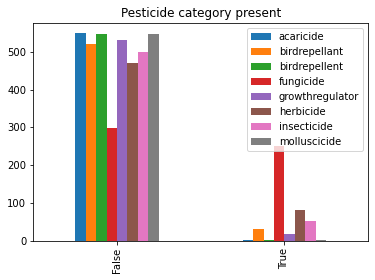

<Figure size 432x288 with 0 Axes>

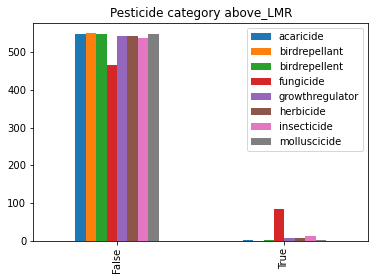

<Figure size 432x288 with 0 Axes>

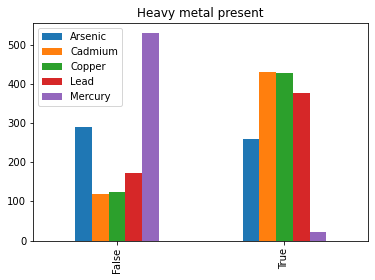

<Figure size 432x288 with 0 Axes>

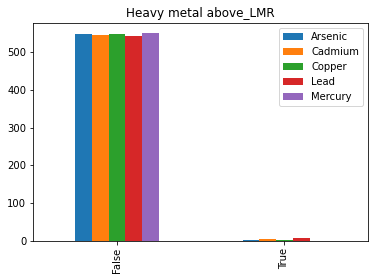

In [4]:
import matplotlib.pyplot as plt
# Look at counts for each category. As you can see, quite unbalanced with a threshold of 0...
idx = pd.IndexSlice
display(phm_flags.loc[:, idx[:, 'present', :]].apply(pd.Series.value_counts).fillna(0))
plt.figure()
phm_flags.loc[:, idx['pesticide_cat', 'present', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Pesticide category present")
display(phm_flags.loc[:, idx[:, 'present', :]].stack().apply(pd.Series.value_counts).fillna(0))
display(phm_flags.loc[:, idx[:, 'above_LMR', :]].apply(pd.Series.value_counts).fillna(0))
plt.figure()
phm_flags.loc[:, idx['pesticide_cat', 'above_LMR', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Pesticide category above_LMR")
display(phm_flags.loc[:, idx[:, 'above_LMR', :]].stack().apply(pd.Series.value_counts).fillna(0))
plt.figure()
phm_flags.loc[:, idx['heavymetal', 'present', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Heavy metal present")
plt.figure()
phm_flags.loc[:, idx['heavymetal', 'above_LMR', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Heavy metal above_LMR")


In [5]:
# Expand the features artifically
def set_year_and_quarter(df, year, quarter):
    new_df = {}
    new_df[year] = df
    df = pd.concat(new_df, names=['Year']).reorder_levels(['Site', 'Year'])
    new_df = {}
    new_df[quarter] = df
    df = pd.concat(new_df, names=['Quarter']).reorder_levels(['Site', 'Year', 'Quarter'])
    return df

def create_history_for_features(features, year, quarter, percent_noise=0.2):
    # Just fetching from a random distribution with some noise here.
    df = features.apply(lambda x: x*np.random.uniform(1-percent_noise, 1+percent_noise, len(x)))
    df = set_year_and_quarter(df, year, quarter)
    return df

def create_fictive_history(features, phm, validation_year_period, percent_noise=0.2):
    # This is generating too much data as not every site has 4 years and 4 periods.
    # But the merge later will take care of that.
    years = list(phm.index.get_level_values('Year').unique())
    quarters = list(phm.index.get_level_values('Quarter').unique())
    all_data = []
    for year in years:
        for quarter in quarters:
            if (year, quarter) in validation_year_period:
                # Use real values
                new_features = set_year_and_quarter(features, year, quarter).assign(DataType="validation")
            else:
                # Use fictive values
                new_features = create_history_for_features(features, year, quarter, percent_noise=percent_noise).assign(DataType="training")
            new_features.reset_index().set_index(new_features.index.names + ['DataType'])
            all_data.append(new_features)
    return pd.concat(all_data, axis=0)

validation_year_period = [("2020", "P1"), ("2020", "P2"), ("2020", "P3"), ("2020", "P4")]
fictive = create_fictive_history(features, phm_flags, validation_year_period)
fictive

dist                                             \
CLC                          111         112          121          122  123   
Site   Year Quarter                                                           
B0012  2020 P1       1020.033273  564.609800   117.220148     0.000000  0.0   
B0017  2020 P1          0.000000  230.733942  1457.209438     0.000000  0.0   
B0019  2020 P1          0.000000    0.000000     0.000000     0.000000  0.0   
B0021  2020 P1          0.000000    0.000000     0.000000     0.000000  0.0   
B0023  2020 P1          0.000000    0.000000     0.000000     0.000000  0.0   
...                          ...         ...          ...          ...  ...   
F0069  2019 P4          0.000000  711.736891     0.000000     0.000000  0.0   
F0071  2019 P4          0.000000    0.000000   799.329896     0.000000  0.0   
F0073  2019 P4          0.000000    0.000000     0.000000     0.000000  0.0   
F0075  2019 P4          0.000000  761.327207   355.170440  1269.305971  0.0   
FE0001 2019 P4          0.000000    0.000000     0.000000     0.000000  0.0   

                                                              ...  \
CLC                  124          131  133  141          142  ...   
Site   Year Quarter                                           ...   
B0012  2020 P1       0.0     0.000000  0.0  0.0     0.000000  ...   
B0017  2020 P1       0.0     0.000000  0.0  0.0     0.000000  ...   
B0019  2020 P1       0.0     0.000000  0.0  0.0     0.000000  ...   
B0021  2020 P1       0.0     0.000000  0.0  0.0     0.000000  ...   
B0023  2020 P1       0.0     0.000000  0.0  0.0  1223.368654  ...   
...                  ...          ...  ...  ...          ...  ...   
F0069  2019 P4       0.0     0.000000  0.0  0.0  1208.353401  ...   
F0071  2019 P4       0.0  1212.224334  0.0  0.0     0.000000  ...   
F0073  2019 P4       0.0     0.000000  0.0  0.0     0.000000  ...   
F0075  2019 P4       0.0     0.000000  0.0  0.0     0.000000  ...   
FE0001 2019 P4       0.0     0.000000  0.0  0.0     0.000000  ...   

                          surface                                             \
CLC                           313  322           324  331           412  423   
Site   Year Quarter                                                            
B0012  2020 P1       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
B0017  2020 P1       1.871540e+06  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
B0019  2020 P1       1.330174e+06  0.0  0.000000e+00  0.0  3.786370e+05  0.0   
B0021  2020 P1       3.620488e+06  0.0  0.000000e+00  0.0  9.421463e+05  0.0   
B0023  2020 P1       6.865176e+04  0.0  6.979889e+05  0.0  1.809062e+06  0.0   
...                           ...  ...           ...  ...           ...  ...   
F0069  2019 P4       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
F0071  2019 P4       0.000000e+00  0.0  8.616099e+05  0.0  0.000000e+00  0.0   
F0073  2019 P4       5.900216e+03  0.0  1.705274e+06  0.0  0.000000e+00  0.0   
F0075  2019 P4       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
FE0001 2019 P4       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   

                                                          DataType  
CLC                            511            512  523              
Site   Year Quarter                                                 
B0012  2020 P1       486328.326111       0.000000  0.0  validation  
B0017  2020 P1            0.000000       0.000000  0.0  validation  
B0019  2020 P1            0.000000       0.000000  0.0  validation  
B0021  2020 P1            0.000000       0.000000  0.0  validation  
B0023  2020 P1            0.000000       0.000000  0.0  validation  
...                            ...            ...  ...         ...  
F0069  2019 P4            0.000000       0.000000  0.0    training  
F0071  2019 P4            0.000000  663218.244335  0.0    training  
F0073  2019 P4            0.000000       0.000000  0.0    training  
F0075

In [6]:
def get_full_dataset(fictive, phm_flags):
    # Add column level
    fictive_p = pd.concat([fictive], axis=1, keys=['features'])
    # Twice because the number of levels for features and target must be equal to be able to merge them
    fictive_p = pd.concat([fictive_p], axis=1, keys=['features'])
    target_p = pd.concat([phm_flags], axis=1, keys=['target'])
    # This will remove the (year, quarter) pairs from the fictive dataset that don't actually exist as measurements for a site
    full_dataset = fictive_p.merge(target_p, left_index=True, right_index=True)
    # Full dataset containing the features and the targets.
    full_dataset = full_dataset.reset_index().set_index(['Site','Year', 'Quarter', ('features', 'features', 'DataType')])
    full_dataset.index.names = full_dataset.index.names[:-1] + ['DataType']
    return full_dataset

full_dataset = get_full_dataset(fictive, phm_flags)
full_dataset

C:\Users\Guillaume\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
C:\Users\Guillaume\anaconda3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


features                            \
                                   features                             
                                       dist                             
CLC                                     111          112          121   
Site   Year Quarter DataType                                            
B0012  2020 P1      validation  1020.033273   564.609800   117.220148   
B0017  2020 P1      validation     0.000000   230.733942  1457.209438   
B0019  2020 P1      validation     0.000000     0.000000     0.000000   
B0021  2020 P1      validation     0.000000     0.000000     0.000000   
B0023  2020 P1      validation     0.000000     0.000000     0.000000   
...                                     ...          ...          ...   
F0035  2019 P4      training       0.000000     0.000000     0.000000   
F0039  2019 P4      training       0.000000  1236.481930   713.840057   
F0041  2019 P4      training       0.000000     0.000000     0.000000   
F0043  2019 P4      training       0.000000   914.043689   987.213555   
FE0001 2019 P4      training       0.000000     0.000000     0.000000   

                                                                   \
                                                                    
                                                                    
CLC                                     122  123         124  131   
Site   Year Quarter DataType                                        
B0012  2020 P1      validation     0.000000  0.0    0.000000  0.0   
B0017  2020 P1      validation     0.000000  0.0    0.000000  0.0   
B0019  2020 P1      validation     0.000000  0.0    0.000000  0.0   
B0021  2020 P1      validation     0.000000  0.0    0.000000  0.0   
B0023  2020 P1      validation     0.000000  0.0    0.000000  0.0   
...                                     ...  ...         ...  ...   
F0035  2019 P4      training       0.000000  0.0    0.000000  0.0   
F0039  2019 P4      training    1018.202942  0.0    0.000000  0.0   
F0041  2019 P4      training     276.072121  0.0    0.000000  0.0   
F0043  2019 P4      training       0.000000  0.0  753.231659  0.0   
FE0001 2019 P4      training       0.000000  0.0    0.000000  0.0   

                                                                      ...  \
                                                                      ...   
                                                                      ...   
CLC                                     133         141          142  ...   
Site   Year Quarter DataType                                          ...   
B0012  2020 P1      validation     0.000000    0.000000     0.000000  ...   
B0017  2020 P1      validation     0.000000    0.000000     0.000000  ...   
B0019  2020 P1      validation     0.000000    0.000000     0.000000  ...   
B0021  2020 P1      validation     0.000000    0.000000     0.000000  ...   
B0023  2020 P1      validation     0.000000    0.000000  1223.368654  ...   
...                                     ...         ...          ...  ...   
F0035  2019 P4      training       0.000000    0.000000     0.000000  ...   
F0039  2019 P4      training    1550.117974    0.000000     0.000000  ...   
F0041  2019 P4      training       0.000000  821.804889  1331.882196  ...   
F0043  2019 P4      training       0.000000    0.000000  1193.221206  ...   
FE0001 2019 P4      training       0.000000    0.000000     0.000000  ...   

                                   target                                \
                               heavymetal                                 
                                above_LMR                                 
CLC                               Arsenic Cadmium Copper   Lead Mercury   
Site   Year Quarter DataType                                              
B0012  2020 P1      validation      False   False  False  False   False   
B0017  2020 P1      validation      False   False  False  False   False   
B00

In [7]:
# Just a quick dirty test.
sub_target = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['above_LMR'] and c[3] == 'Lead']]

idx = pd.IndexSlice
X_train = full_dataset["features"].loc(axis=0)[:, :, :, "training"]
X_test = full_dataset["features"].loc(axis=0)[:, :, :, 'validation']
Y_train = sub_target.loc(axis=0)[:, :, :, 'training']
Y_test = sub_target.loc(axis=0)[:, :, :, 'validation']

from sklearn.svm import SVC
from sklearn.metrics import classification_report
clf = SVC()
clf.fit(X_train, Y_train)

print(classification_report(clf.predict(X_test), Y_test))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99       194
        True       0.00      0.00      0.00         0

    accuracy                           0.98       194
   macro avg       0.50      0.49      0.50       194
weighted avg       1.00      0.98      0.99       194



C:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Correlation matrix

In [8]:
features = full_dataset["features"].loc(axis=1)["features", 'surface', :,:]
features

features                              \
                                      surface                               
CLC                                       111           112           121   
Site   Year Quarter DataType                                                
B0012  2020 P1      validation  213419.497009  3.756405e+06  2.068585e+06   
B0017  2020 P1      validation       0.000000  1.755395e+06  3.380723e+03   
B0019  2020 P1      validation       0.000000  0.000000e+00  0.000000e+00   
B0021  2020 P1      validation       0.000000  0.000000e+00  0.000000e+00   
B0023  2020 P1      validation       0.000000  0.000000e+00  0.000000e+00   
...                                       ...           ...           ...   
F0035  2019 P4      training         0.000000  0.000000e+00  0.000000e+00   
F0039  2019 P4      training         0.000000  4.406479e+04  3.560310e+05   
F0041  2019 P4      training         0.000000  0.000000e+00  2.980135e+06   
F0043  2019 P4      training         0.000000  1.518936e+06  6.461762e+05   
FE0001 2019 P4      training         0.000000  4.015657e+05  0.000000e+00   

                                                                       \
                                                                        
CLC                                       122  123           124  131   
Site   Year Quarter DataType                                            
B0012  2020 P1      validation       0.000000  0.0  0.000000e+00  0.0   
B0017  2020 P1      validation       0.000000  0.0  0.000000e+00  0.0   
B0019  2020 P1      validation       0.000000  0.0  0.000000e+00  0.0   
B0021  2020 P1      validation       0.000000  0.0  0.000000e+00  0.0   
B0023  2020 P1      validation       0.000000  0.0  0.000000e+00  0.0   
...                                       ...  ...           ...  ...   
F0035  2019 P4      training         0.000000  0.0  0.000000e+00  0.0   
F0039  2019 P4      training    261886.728666  0.0  0.000000e+00  0.0   
F0041  2019 P4      training    263823.918559  0.0  0.000000e+00  0.0   
F0043  2019 P4      training         0.000000  0.0  1.143699e+06  0.0   
FE0001 2019 P4      training         0.000000  0.0  0.000000e+00  0.0   

                                                                            \
                                                                             
CLC                                      133            141            142   
Site   Year Quarter DataType                                                 
B0012  2020 P1      validation      0.000000       0.000000       0.000000   
B0017  2020 P1      validation      0.000000       0.000000       0.000000   
B0019  2020 P1      validation      0.000000       0.000000       0.000000   
B0021  2020 P1      validation      0.000000       0.000000       0.000000   
B0023  2020 P1      validation      0.000000       0.000000  194534.061432   
...                                      ...            ...            ...   
F0035  2019 P4      training        0.000000       0.000000       0.000000   
F0039  2019 P4      training    47698.495723       0.000000       0.000000   
F0041  2019 P4      training        0.000000  327180.394375   21464.493612   
F0043  2019 P4      training        0.000000       0.000000  255009.084559   
FE0001 2019 P4      training        0.000000       0.000000       0.000000   

                                ...                                   \
                                ...                                    
CLC                             ...           312           313  322   
Site   Year Quarter DataType    ...                                    
B0012  2020 P1      validation  ...  0.000000e+00  0.000000e+00  0.0   
B0017  2020 P1      validation  ...  1.097484e+06  1.871540e+06  0.0   
B0019  2020 P1      validation  ...  5.146666e+06  1.330174e+06  0.0   
B0021  2020 P1      validation  ...  1.572156e+06  3.620488e+06  0.0   
B0023  2020 P1      validation  ...  2

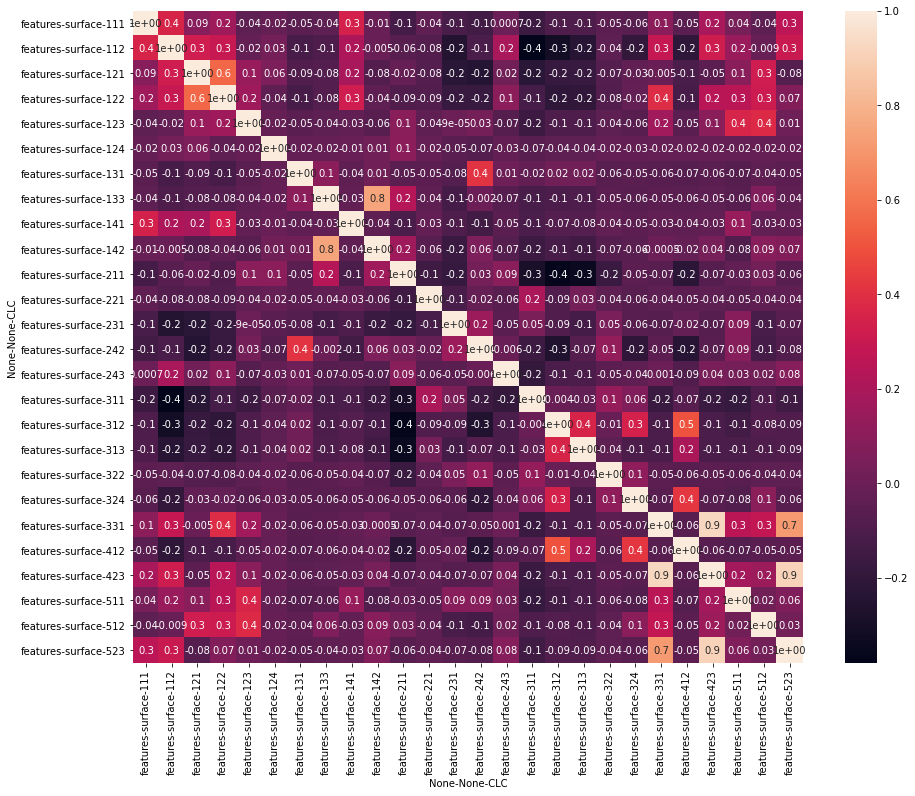

In [9]:
import seaborn as sns
corrMatrix = features.corr()
fig_dims = (15, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(corrMatrix, annot=True, fmt='.1', ax = ax)
plt.show()

#### PCA

In [10]:
#heavy_metal_periods['Lead'].mean() 0.221
#heavy_metal_periods['Cadmium'].mean() 0.187
#heavy_metal_periods['Arsenic'].mean() 0.037
#heavy_metal_periods['Mercury'].mean() 0.0004
#heavy_metal_periods['Copper'].mean() 7.972
#heavy_metal_periods['Chromium'].mean() 0.105
#heavy_metal_periods['Zinc'].mean() 38.68

In [11]:
X_train = full_dataset["features"].loc(axis=0)[:, :, :, 'training']
X_test = full_dataset["features"].loc(axis=0)[:, :, :, 'validation']

In [12]:
X_train

features                                         \
                                 dist                                          
CLC                               111          112          121          122   
Site   Year Quarter DataType                                                   
B0017  2017 P1      training      0.0   200.454177  1191.541493     0.000000   
B0019  2017 P1      training      0.0     0.000000     0.000000     0.000000   
B0021  2017 P1      training      0.0     0.000000     0.000000     0.000000   
B0023  2017 P1      training      0.0     0.000000     0.000000     0.000000   
B0037  2017 P1      training      0.0   156.294409     0.000000     0.000000   
...                               ...          ...          ...          ...   
F0035  2019 P4      training      0.0     0.000000     0.000000     0.000000   
F0039  2019 P4      training      0.0  1236.481930   713.840057  1018.202942   
F0041  2019 P4      training      0.0     0.000000     0.000000   276.072121   
F0043  2019 P4      training      0.0   914.043689   987.213555     0.000000   
FE0001 2019 P4      training      0.0     0.000000     0.000000     0.000000   

                                                                             \
                                                                              
CLC                           123         124  131          133         141   
Site   Year Quarter DataType                                                  
B0017  2017 P1      training  0.0    0.000000  0.0     0.000000    0.000000   
B0019  2017 P1      training  0.0    0.000000  0.0     0.000000    0.000000   
B0021  2017 P1      training  0.0    0.000000  0.0     0.000000    0.000000   
B0023  2017 P1      training  0.0    0.000000  0.0     0.000000    0.000000   
B0037  2017 P1      training  0.0    0.000000  0.0     0.000000    0.000000   
...                           ...         ...  ...          ...         ...   
F0035  2019 P4      training  0.0    0.000000  0.0     0.000000    0.000000   
F0039  2019 P4      training  0.0    0.000000  0.0  1550.117974    0.000000   
F0041  2019 P4      training  0.0    0.000000  0.0     0.000000  821.804889   
F0043  2019 P4      training  0.0  753.231659  0.0     0.000000    0.000000   
FE0001 2019 P4      training  0.0    0.000000  0.0     0.000000    0.000000   

                                           ...                              \
                                           ...       surface                 
CLC                                   142  ...           312           313   
Site   Year Quarter DataType               ...                               
B0017  2017 P1      training     0.000000  ...  1.126424e+06  1.824758e+06   
B0019  2017 P1      training     0.000000  ...  4.533346e+06  1.512109e+06   
B0021  2017 P1      training     0.000000  ...  1.316451e+06  3.457440e+06   
B0023  2017 P1      training  1409.615022  ...  2.317899e+06  7.077947e+04   
B0037  2017 P1      training   823.305966  ...  3.598624e+04  3.438055e+05   
...                                   ...  ...           ...           ...   
F0035  2019 P4      training     0.000000  ...  8.763186e+05  2.638997e+05   
F0039  2019 P4      training     0.000000  ...  0.000000e+00  2.723956e+05   
F0041  2019 P4      training  1331.882196  ...  0.000000e+00  0.000000e+00   
F0043  2019 P4      training  1193.221206  ...  0.000000e+00  0.000000e+00   
FE0001 2019 P4      training     0.000000  ...  0.000000e+00  0.000000e+00   

                                                                               \
                                                                                
CLC                           322            324  331           412  423  511   
Site   Year Quarter DataType                                                    
B0017  2017 P1      training  0.0       0.000000  0.0  0.000000e+00  0.0  0.0   
B0019  2017 P1      training  0.0       0.000000  0.0  3.440932e+0

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [15]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([1.51709106e-01, 8.20297377e-02, 7.29039492e-02, 6.51971495e-02,
       5.94626746e-02, 4.73402166e-02, 4.44552385e-02, 4.21245382e-02,
       4.09754166e-02, 3.81521553e-02, 3.48190549e-02, 3.15032886e-02,
       2.96611771e-02, 2.82180767e-02, 2.44513103e-02, 2.14754132e-02,
       1.98871134e-02, 1.79036111e-02, 1.67129747e-02, 1.53827627e-02,
       1.30658499e-02, 1.25025390e-02, 1.11399140e-02, 1.00362391e-02,
       8.87562891e-03, 8.62736184e-03, 7.68677875e-03, 7.28761909e-03,
       5.17859172e-03, 4.98368597e-03, 4.37098423e-03, 3.40783872e-03,
       3.16396050e-03, 2.69140676e-03, 2.37363470e-03, 1.99567917e-03,
       1.61750374e-03, 1.52433172e-03, 1.18846258e-03, 8.06059391e-04,
       5.38297036e-04, 5.14032484e-04, 3.63574504e-04, 3.36687082e-04,
       3.30519982e-04, 2.49250688e-04, 2.18523540e-04, 1.91623002e-04,
       1.53841965e-04, 1.17663219e-04, 7.99022122e-05, 1.70495014e-05])

<function matplotlib.pyplot.show(close=None, block=None)>

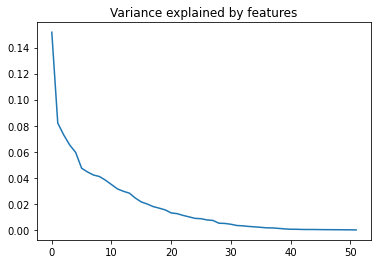

In [16]:
plt.plot(explained_variance)
plt.title("Variance explained by features")
plt.show

In [17]:
explained_variance[0:30].sum()

0.9737491732705538

#### Lazy processing - Heavy metal/above_LMR/Lead

In [18]:
sub_target = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['above_LMR'] and c[3] == 'Lead']]

idx = pd.IndexSlice
X_train = full_dataset["features"].loc(axis=0)[:, :, :, 'training']
X_test = full_dataset["features"].loc(axis=0)[:, :, :, 'validation']
y_train = sub_target.loc(axis=0)[:, :, :, 'training']
y_test = sub_target.loc(axis=0)[:, :, :, 'validation']

In [19]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [20]:
y_train.target.heavymetal.above_LMR.Lead.value_counts()

False    353
True     105
Name: Lead, dtype: int64

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA(n_components=35)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [22]:
pca_df = pd.DataFrame(pca.components_)

In [23]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

C:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
100%|██████████| 30/30 [00:00<00:00, 46.66it/s]

[10:10:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [24]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)

neigh.fit(X_train, y_train)

y_pred_knn = neigh.predict(X_test)

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       191
        True       0.33      0.33      0.33         3

    accuracy                           0.98       194
   macro avg       0.66      0.66      0.66       194
weighted avg       0.98      0.98      0.98       194



#### Cross validation

In [26]:
sub_target = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['above_LMR'] and c[3] == 'Lead']]

idx = pd.IndexSlice
X_cv = full_dataset["features"]
y_cv = sub_target

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

sm = SMOTE(random_state=42, sampling_strategy=0.2, k_neighbors=2)
X_cv, y_cv = sm.fit_resample(X_cv, y_cv)

clf_forest=RandomForestClassifier(n_estimators=100, random_state=42)
scores_randfor = cross_val_score(clf_forest, X_cv, y_cv, cv=10, scoring="f1")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_randfor.mean(), scores_randfor.std()))

0.98 accuracy with a standard deviation of 0.03


In [28]:
scores_randfor

array([0.90909091, 0.95652174, 0.95238095, 0.95238095, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

### Predict Presence of heavy metal

In [29]:
target_presence_hm = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['present']]]
target_presence_hm

target                              
                               heavymetal                              
                                  present                              
CLC                               Arsenic Cadmium Copper   Lead Mercury
Site   Year Quarter DataType                                           
B0012  2020 P1      validation       True    True   True   True   False
B0017  2020 P1      validation      False    True   True   True   False
B0019  2020 P1      validation      False    True   True   True   False
B0021  2020 P1      validation      False    True   True   True   False
B0023  2020 P1      validation       True    True   True   True   False
...                                   ...     ...    ...    ...     ...
F0035  2019 P4      training        False   False  False  False   False
F0039  2019 P4      training        False   False  False  False   False
F0041  2019 P4      training         True    True   True   True   False
F0043  2019 P4      training         True    True   True   True   False
FE0001 2019 P4      training        False    True   True  False   False

[550 rows x 5 columns]

In [30]:
def presence_hm(x):
    idx = pd.IndexSlice
    if (x["target", "heavymetal", "present", "Arsenic"] == False and
        x["target", "heavymetal", "present", "Cadmium"] == False and 
        x["target", "heavymetal", "present", "Copper"] == False and 
        x["target", "heavymetal", "present", "Lead"] == False and 
        x["target", "heavymetal", "present", "Mercury"] == False):
        
        return False
    
    else:
        
        return True

In [31]:
idx = pd.IndexSlice
target_presence_hm["target", "heavymetal", "present", "hm_present"] = target_presence_hm.apply(presence_hm, axis=1)
target_presence_hm

target                                \
                               heavymetal                                 
                                  present                                 
CLC                               Arsenic Cadmium Copper   Lead Mercury   
Site   Year Quarter DataType                                              
B0012  2020 P1      validation       True    True   True   True   False   
B0017  2020 P1      validation      False    True   True   True   False   
B0019  2020 P1      validation      False    True   True   True   False   
B0021  2020 P1      validation      False    True   True   True   False   
B0023  2020 P1      validation       True    True   True   True   False   
...                                   ...     ...    ...    ...     ...   
F0035  2019 P4      training        False   False  False  False   False   
F0039  2019 P4      training        False   False  False  False   False   
F0041  2019 P4      training         True    True   True   True   False   
F0043  2019 P4      training         True    True   True   True   False   
FE0001 2019 P4      training        False    True   True  False   False   

                                           
                                           
                                           
CLC                            hm_present  
Site   Year Quarter DataType               
B0012  2020 P1      validation       True  
B0017  2020 P1      validation       True  
B0019  2020 P1      validation       True  
B0021  2020 P1      validation       True  
B0023  2020 P1      validation       True  
...                                   ...  
F0035  2019 P4      training        False  
F0039  2019 P4      training        False  
F0041  2019 P4      training         True  
F0043  2019 P4      training         True  
FE0001 2019 P4      training         True  

[550 rows x 6 columns]

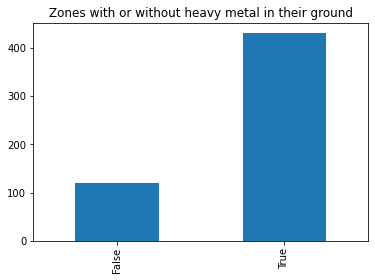

In [32]:
target_presence_hm["target", "heavymetal", "present", "hm_present"].value_counts().plot(kind="bar")
plt.title("Zones with or without heavy metal in their ground")
plt.show()

In [33]:
features_presence_hm = full_dataset["features"]

In [34]:
X_train_presence_hm = features_presence_hm.loc(axis=0)[:, :, :, 'training']
X_test_presence_hm = features_presence_hm.loc(axis=0)[:, :, :, 'validation']
y_train_presence_hm = target_presence_hm.loc(axis=0)[:, :, :, 'training']
y_test_presence_hm = target_presence_hm.loc(axis=0)[:, :, :, 'validation']
y_train_presence_hm = y_train_presence_hm["target", "heavymetal", "present", "hm_present"]
y_test_presence_hm = y_test_presence_hm["target", "heavymetal", "present", "hm_present"]

In [35]:
sc = StandardScaler()
X_train_presence_hm = sc.fit_transform(X_train_presence_hm)
X_test_presence_hm = sc.transform(X_test_presence_hm)

In [36]:
clf_forest_hm=RandomForestClassifier(random_state=42)

params= {
    'n_estimators' : [10,20,50,100,150,200,300,400,500],
    'max_depth' : [5,10,15,20,25,30],
    'max_features' : np.arange(0.1,1,0.1).tolist()
    
}

In [37]:
'''from sklearn.model_selection import GridSearchCV
# Setting up the grid search that will test every combination of parameters
gridsearch = GridSearchCV(estimator = clf_forest_hm,
                        param_grid = params,
                        scoring = 'f1', 
                        cv = 10, # Use 5 folds
                        verbose = 1,
                        n_jobs = -1 #Use all but one CPU core
                        )

# As we are doing cross-validation on the training set, the testing set X_test is untouched
result = gridsearch.fit(X_train_presence_hm, y_train_presence_hm)'''

"from sklearn.model_selection import GridSearchCV\n# Setting up the grid search that will test every combination of parameters\ngridsearch = GridSearchCV(estimator = clf_forest_hm,\n                        param_grid = params,\n                        scoring = 'f1', \n                        cv = 10, # Use 5 folds\n                        verbose = 1,\n                        n_jobs = -1 #Use all but one CPU core\n                        )\n\n# As we are doing cross-validation on the training set, the testing set X_test is untouched\nresult = gridsearch.fit(X_train_presence_hm, y_train_presence_hm)"

In [38]:
#print("The best parameters are :", result.best_params_)
#print("The best f1 is {:.2f}%:".format(result.best_score_ * 100))

In [39]:
sm = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_presence_hm, y_train_presence_hm = sm.fit_resample(X_train_presence_hm, y_train_presence_hm)

In [40]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,random_state=42, max_depth=20, max_features=0.9)

clf.fit(X_train_presence_hm, y_train_presence_hm)

y_pred_rf = clf.predict(X_test_presence_hm)

In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test_presence_hm,y_pred_rf))

              precision    recall  f1-score   support

       False       0.49      0.42      0.45        43
        True       0.84      0.87      0.86       151

    accuracy                           0.77       194
   macro avg       0.66      0.65      0.65       194
weighted avg       0.76      0.77      0.77       194



##### Cross validation

In [42]:
sm = SMOTE(random_state=42, sampling_strategy=0.5)
features_presence_hm, target_presence_hm = sm.fit_resample(features_presence_hm, target_presence_hm["target", "heavymetal", "present", "hm_present"])

In [43]:
sc = StandardScaler()
features_presence_hm = sc.fit_transform(features_presence_hm)

In [44]:
clf_forest_hm=RandomForestClassifier(n_estimators=100,random_state=42, max_depth=20, max_features=0.9)
scores_randfor = cross_val_score(clf_forest_hm, features_presence_hm, target_presence_hm, cv=10, scoring="f1_weighted")
print("%0.2f de f1 with a standard deviation of %0.2f" % (scores_randfor.mean(), scores_randfor.std()))

0.83 de f1 with a standard deviation of 0.10


#### Predict if Arsenic is present

In [45]:
target_data_arsenic = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['present'] and c[3] == 'Arsenic']]
target_data_arsenic

,,,,target
,,,,heavymetal
,,,,present
,,,CLC,Arsenic
Site,Year,Quarter,DataType,
B0012,2020,P1,validation,True
B0017,2020,P1,validation,False
B0019,2020,P1,validation,False
B0021,2020,P1,validation,False
B0023,2020,P1,validation,True
...,...,...,...,...


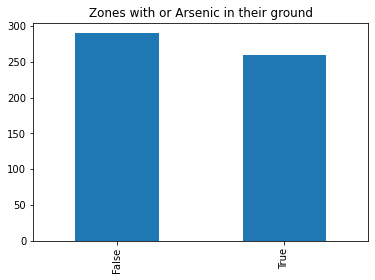

In [46]:
target_data_arsenic["target", "heavymetal", "present", "Arsenic"].value_counts().plot(kind="bar")
plt.title("Zones with or Arsenic in their ground")
plt.show()

In [47]:
features_presence_arsenic = full_dataset["features"]

In [48]:
X_train_presence_arsenic = features_presence_arsenic.loc(axis=0)[:, :, :, 'training']
X_test_presence_arsenic = features_presence_arsenic.loc(axis=0)[:, :, :, 'validation']
y_train_presence_arsenic = target_data_arsenic.loc(axis=0)[:, :, :, 'training']
y_test_presence_arsenic = target_data_arsenic.loc(axis=0)[:, :, :, 'validation']

In [49]:
sc = StandardScaler()
X_train_presence_arsenic = sc.fit_transform(X_train_presence_arsenic)
X_test_presence_arsenic = sc.transform(X_test_presence_arsenic)

In [50]:
clf_forest_arsenic=RandomForestClassifier(random_state=42)

params= {
    'n_estimators' : [10,20,50,100,150,200,300,400,500],
    'max_depth' : [5,10,15,20,25,30],
    'max_features' : np.arange(0.1,1,0.1).tolist()
    
}

In [51]:
'''# Setting up the grid search that will test every combination of parameters
gridsearch = GridSearchCV(estimator = clf_forest_arsenic,
                        param_grid = params,
                        scoring = 'f1_weighted', 
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1 #Use all but one CPU core
                        )

# As we are doing cross-validation on the training set, the testing set X_test is untouched
result = gridsearch.fit(X_train_presence_arsenic, y_train_presence_arsenic)'''

"# Setting up the grid search that will test every combination of parameters\ngridsearch = GridSearchCV(estimator = clf_forest_arsenic,\n                        param_grid = params,\n                        scoring = 'f1_weighted', \n                        cv = 10, # Use 5 folds\n                        verbose = 1,\n                        n_jobs = -1 #Use all but one CPU core\n                        )\n\n# As we are doing cross-validation on the training set, the testing set X_test is untouched\nresult = gridsearch.fit(X_train_presence_arsenic, y_train_presence_arsenic)"

In [52]:
#print("The best parameters are :", result.best_params_)
#print("The best f1 is {:.2f}%:".format(result.best_score_ * 100))

In [53]:
from sklearn.ensemble import RandomForestClassifier

clf_arsenic = RandomForestClassifier(n_estimators=150,random_state=42, max_depth=20, max_features=0.2)

clf_arsenic.fit(X_train_presence_arsenic, y_train_presence_arsenic)

y_pred_rf = clf_arsenic.predict(X_test_presence_arsenic)

In [54]:
print(classification_report(y_test_presence_arsenic,y_pred_rf))

              precision    recall  f1-score   support

       False       0.71      0.62      0.66       106
        True       0.60      0.69      0.65        88

    accuracy                           0.65       194
   macro avg       0.66      0.66      0.65       194
weighted avg       0.66      0.65      0.66       194



##### Cross validation

In [55]:
sc = StandardScaler()
features_presence_arsenic = sc.fit_transform(features_presence_arsenic)

In [56]:
clf_forest_arsenic=RandomForestClassifier(n_estimators=150,random_state=42, max_depth=20, max_features=0.2)
scores_randfor = cross_val_score(clf_forest_arsenic, features_presence_arsenic, target_data_arsenic, cv=10, scoring="f1_weighted")
print("%0.2f de f1 with a standard deviation of %0.2f" % (scores_randfor.mean(), scores_randfor.std()))

0.68 de f1 with a standard deviation of 0.06


### Check if cadmium is in the ground

In [57]:
target_data_cadmium = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['present'] and c[3] == 'Cadmium']]
target_data_cadmium

,,,,target
,,,,heavymetal
,,,,present
,,,CLC,Cadmium
Site,Year,Quarter,DataType,
B0012,2020,P1,validation,True
B0017,2020,P1,validation,True
B0019,2020,P1,validation,True
B0021,2020,P1,validation,True
B0023,2020,P1,validation,True
...,...,...,...,...


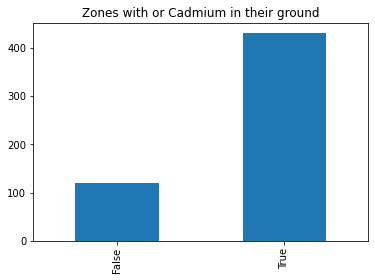

In [58]:
target_data_cadmium["target", "heavymetal", "present", "Cadmium"].value_counts().plot(kind="bar")
plt.title("Zones with or Cadmium in their ground")
plt.show()

In [59]:
features_presence_cadmium = full_dataset["features"]

In [60]:
X_train_presence_cadmium = features_presence_cadmium.loc(axis=0)[:, :, :, 'training']
X_test_presence_cadmium = features_presence_cadmium.loc(axis=0)[:, :, :, 'validation']
y_train_presence_cadmium = target_data_cadmium.loc(axis=0)[:, :, :, 'training']
y_test_presence_cadmium = target_data_cadmium.loc(axis=0)[:, :, :, 'validation']

In [61]:
sc = StandardScaler()
X_train_presence_cadmium = sc.fit_transform(X_train_presence_cadmium)
X_test_presence_cadmium = sc.transform(X_test_presence_cadmium)

In [62]:
sm = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_presence_cadmium, y_train_presence_cadmium = sm.fit_resample(X_train_presence_cadmium, y_train_presence_cadmium)

In [63]:
clf_forest_cadmium=RandomForestClassifier(random_state=42)

params= {
    'n_estimators' : [10,20,50,100,150,200,300,400,500],
    'max_depth' : [5,10,15,20,25,30],
    'max_features' : np.arange(0.1,1,0.1).tolist()
    
}

In [64]:
'''# Setting up the grid search that will test every combination of parameters
gridsearch = GridSearchCV(estimator = clf_forest_cadmium,
                        param_grid = params,
                        scoring = 'f1_weighted', 
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1 
                        )

# As we are doing cross-validation on the training set, the testing set X_test is untouched
result_cadmium = gridsearch.fit(X_train_presence_cadmium, y_train_presence_cadmium)'''

"# Setting up the grid search that will test every combination of parameters\ngridsearch = GridSearchCV(estimator = clf_forest_cadmium,\n                        param_grid = params,\n                        scoring = 'f1_weighted', \n                        cv = 10, \n                        verbose = 1,\n                        n_jobs = -1 \n                        )\n\n# As we are doing cross-validation on the training set, the testing set X_test is untouched\nresult_cadmium = gridsearch.fit(X_train_presence_cadmium, y_train_presence_cadmium)"

In [65]:
#print("The best parameters are :", result_cadmium.best_params_)
#print("The best f1 weighted is {:.2f}%:".format(result_cadmium.best_score_ * 100))

In [66]:
clf_cadmium = RandomForestClassifier(n_estimators=100,random_state=42, max_depth=20, max_features=0.3)

clf_cadmium.fit(X_train_presence_cadmium, y_train_presence_cadmium)

y_pred_cadmium = clf_cadmium.predict(X_test_presence_cadmium)

In [67]:
print(classification_report(y_test_presence_cadmium,y_pred_cadmium))

              precision    recall  f1-score   support

       False       0.55      0.40      0.46        43
        True       0.84      0.91      0.87       151

    accuracy                           0.79       194
   macro avg       0.69      0.65      0.67       194
weighted avg       0.78      0.79      0.78       194



##### Cross validation

In [68]:
sm = SMOTE(random_state=42, sampling_strategy=0.5)
features_presence_cadmium, target_data_cadmium = sm.fit_resample(features_presence_cadmium, target_data_cadmium["target", "heavymetal", "present", "Cadmium"])

In [69]:
sc = StandardScaler()
features_presence_cadmium = sc.fit_transform(features_presence_cadmium)

In [70]:
clf_forest_cadmium=RandomForestClassifier(n_estimators=100,random_state=42, max_depth=20, max_features=0.9)
scores_randfor_cadmium = cross_val_score(clf_forest_cadmium, features_presence_cadmium, target_data_cadmium, cv=10, scoring="balanced_accuracy")
print("%0.2f de f1 with a standard deviation of %0.2f" % (scores_randfor_cadmium.mean(), scores_randfor_cadmium.std()))

0.81 de f1 with a standard deviation of 0.11


## Presence of lead in the ground

In [71]:
target_data_lead = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['present'] and c[3] == 'Lead']]
target_data_lead

,,,,target
,,,,heavymetal
,,,,present
,,,CLC,Lead
Site,Year,Quarter,DataType,
B0012,2020,P1,validation,True
B0017,2020,P1,validation,True
B0019,2020,P1,validation,True
B0021,2020,P1,validation,True
B0023,2020,P1,validation,True
...,...,...,...,...


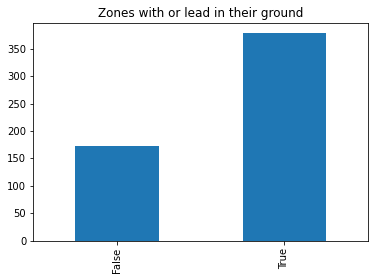

In [72]:
target_data_lead["target", "heavymetal", "present", "Lead"].value_counts().plot(kind="bar")
plt.title("Zones with or lead in their ground")
plt.show()

In [73]:
features_presence_lead = full_dataset["features"]

In [74]:
X_train_presence_lead = features_presence_lead.loc(axis=0)[:, :, :, 'training']
X_test_presence_lead = features_presence_lead.loc(axis=0)[:, :, :, 'validation']
y_train_presence_lead = target_data_lead.loc(axis=0)[:, :, :, 'training']
y_test_presence_lead = target_data_lead.loc(axis=0)[:, :, :, 'validation']

In [75]:
sm = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_presence_lead, y_train_presence_lead = sm.fit_resample(X_train_presence_lead, y_train_presence_lead)

In [76]:
sc = StandardScaler()
X_train_presence_lead = sc.fit_transform(X_train_presence_lead)
X_test_presence_lead = sc.transform(X_test_presence_lead)

In [77]:
clf_forest_lead=RandomForestClassifier(random_state=42)

params= {
    'n_estimators' : [10,20,50,100,150,200,300,400,500],
    'max_depth' : [5,10,15,20,25,30],
    'max_features' : np.arange(0.1,1,0.1).tolist()
    
}

In [78]:
'''from sklearn.model_selection import GridSearchCV
# Setting up the grid search that will test every combination of parameters
gridsearch = GridSearchCV(estimator = clf_forest_lead,
                        param_grid = params,
                        scoring = 'f1_weighted', 
                        cv = 10, 
                        verbose = 1,
                        n_jobs = -1 
                        )

# As we are doing cross-validation on the training set, the testing set X_test is untouched
result_lead = gridsearch.fit(X_train_presence_lead, y_train_presence_lead)'''

"from sklearn.model_selection import GridSearchCV\n# Setting up the grid search that will test every combination of parameters\ngridsearch = GridSearchCV(estimator = clf_forest_lead,\n                        param_grid = params,\n                        scoring = 'f1_weighted', \n                        cv = 10, \n                        verbose = 1,\n                        n_jobs = -1 \n                        )\n\n# As we are doing cross-validation on the training set, the testing set X_test is untouched\nresult_lead = gridsearch.fit(X_train_presence_lead, y_train_presence_lead)"

In [79]:
#print("The best parameters are :", result_lead.best_params_)
#print("The best f1 weighted is {:.2f}%:".format(result_lead.best_score_ * 100))

In [80]:
clf_lead = RandomForestClassifier(n_estimators=200,random_state=42, max_depth=20, max_features=0.1)

clf_lead.fit(X_train_presence_lead, y_train_presence_lead)

y_pred_lead = clf_lead.predict(X_test_presence_lead)

In [81]:
print(classification_report(y_test_presence_lead,y_pred_lead))

              precision    recall  f1-score   support

       False       0.67      0.59      0.62        58
        True       0.83      0.88      0.85       136

    accuracy                           0.79       194
   macro avg       0.75      0.73      0.74       194
weighted avg       0.78      0.79      0.78       194



##### Cross validation

In [82]:
sm = SMOTE(random_state=42, sampling_strategy=0.5)
features_presence_lead, target_data_lead = sm.fit_resample(features_presence_lead, target_data_lead["target", "heavymetal", "present", "Lead"])

In [83]:
sc = StandardScaler()
features_presence_lead = sc.fit_transform(features_presence_lead)

In [84]:
clf_forest_lead=RandomForestClassifier(n_estimators=200,random_state=42, max_depth=20, max_features=0.1)
scores_randfor_lead= cross_val_score(clf_forest_lead, features_presence_lead, target_data_lead, cv=10, scoring="balanced_accuracy")
print("%0.2f de f1 with a standard deviation of %0.2f" % (scores_randfor_lead.mean(), scores_randfor_lead.std()))

0.80 de f1 with a standard deviation of 0.05
